## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

In [1]:
pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.4 MB/s eta 0:00:00


Do this in order to install Reddit Python library:
`pip install praw`.

Library docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html



Now we need to setup Reddit data fetching. For this we need to have a Reddit account.

We'll use posts from https://www.reddit.com/r/Paranormal/comments/gc4ive/i_made_another_big_list_of_paranormal_and_mystery/ for inspiration.

Now, create `client_id` and `client_secret`.

How?
  - Create a Reddit account if you don't have one yet
  - Go to https://www.reddit.com/prefs/apps and click `create an app`
  - Pick `script` app type. Name and description can be anything, but make sure to specify `http://localhost:8080` as `redirect uri`
  - Press `create app`. Your `client_id` is the string under **personal use script** and `client_secret` is the string next to **secret**

In [2]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = 'Zxxz7F7yMwXMlGzYpcH4gg',
    client_secret = 'OXc9vxYSJChijojN9zMxsKLdw2jRNA',
    user_agent = 'praw'
)

# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    for i in range(min(50, len(commentsList))):
        pandas_list.append([i, commentsList[i].body])
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

In [3]:
# test getComments()
df = getComments('1n9pg5')

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Install libraries & load data

In [4]:
# Install spacy quietly
!pip install spacy -q

In [5]:
# Download english language model
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
# Install wordcloud
!pip install wordcloud

1. Import pandas, numpy, spacy, sklearn (TfidfVectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud.

   `en_core_web_sm` is a trained English pipeline.

In [7]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Read reddit comments and put it in a DataFrame named `corpus`.

In [8]:
corpus = getComments('g88ccd')#pd.read_csv('./sample_data.csv')

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [9]:
print(corpus.shape)
corpus.head()

(50, 2)


,id,description
0,0,I was home alone at my dad's while he was work...
1,1,Was home alone one night and it was close to H...
2,2,The scariest thing that happened to me I didnt...
3,3,Probably pretty lame compared to most stories ...
4,4,[deleted]


In [10]:
print('Description of the first product : ',corpus.loc[0,'description'])

Description of the first product :  I was home alone at my dad's while he was working nights, making my dinner and everything. I was probably about 14 or 15 at the time. I was watching tv while my potatoes were cooking when I head something slam into the front door. I grab my pocket knife and check it out, nothing. About 10 minutes later I hear another bang on the front door, repeat and still nothing. Really freaked me out cause we'd had a few houses get broken into on my street. 

Turns out I didnt put enough holes into my baked potatoes and they exploded in the oven. :(


### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Use `str` methods to clean the texts. Save cleaned-up text into a column named `clean_description`.

In [11]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ")
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ")
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  I was home alone at my dad's while he was working nights, making my dinner and everything. I was probably about 14 or 15 at the time. I was watching tv while my potatoes were cooking when I head something slam into the front door. I grab my pocket knife and check it out, nothing. About 10 minutes later I hear another bang on the front door, repeat and still nothing. Really freaked me out cause we'd had a few houses get broken into on my street. 

Turns out I didnt put enough holes into my baked potatoes and they exploded in the oven. :(


4. Tranform every character into lowercase.

In [12]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  i was home alone at my dad's while he was working nights, making my dinner and everything. i was probably about 14 or 15 at the time. i was watching tv while my potatoes were cooking when i head something slam into the front door. i grab my pocket knife and check it out, nothing. about 10 minutes later i hear another bang on the front door, repeat and still nothing. really freaked me out cause we'd had a few houses get broken into on my street. 

turns out i didnt put enough holes into my baked potatoes and they exploded in the oven. :(


5. Use spacy to tokenize the documents and put the result in a new column named `clean_tokens`.

In [13]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,I was home alone at my dad's while he was work...,i was home alone at my dad's while he was work...,"(i, was, home, alone, at, my, dad, 's, while, ..."
1,1,Was home alone one night and it was close to H...,was home alone one night and it was close to h...,"(was, home, alone, one, night, and, it, was, c..."
2,2,The scariest thing that happened to me I didnt...,the scariest thing that happened to me i didnt...,"(the, scariest, thing, that, happened, to, me,..."
3,3,Probably pretty lame compared to most stories ...,probably pretty lame compared to most stories ...,"(probably, pretty, lame, compared, to, most, s..."
4,4,[deleted],[deleted],"([, deleted, ])"


6. Remove the stop words and lemmatize `clean_tokens`

In [14]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,0,I was home alone at my dad's while he was work...,i was home alone at my dad's while he was work...,"[home, dad, work, night, ,, make, dinner, ., p..."
1,1,Was home alone one night and it was close to H...,was home alone one night and it was close to h...,"[home, night, close, halloween, 2015, ., loud,..."
2,2,The scariest thing that happened to me I didnt...,the scariest thing that happened to me i didnt...,"[scary, thing, happen, not, know, actually, ha..."
3,3,Probably pretty lame compared to most stories ...,probably pretty lame compared to most stories ...,"[probably, pretty, lame, compare, story, ., wo..."
4,4,[deleted],[deleted],"[[, delete, ]]"


7. Write all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [15]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,0,I was home alone at my dad's while he was work...,i was home alone at my dad's while he was work...,"[home, dad, work, night, ,, make, dinner, ., p...","home dad work night , make dinner . probably 1..."
1,1,Was home alone one night and it was close to H...,was home alone one night and it was close to h...,"[home, night, close, halloween, 2015, ., loud,...",home night close halloween 2015 . loud ass kno...
2,2,The scariest thing that happened to me I didnt...,the scariest thing that happened to me i didnt...,"[scary, thing, happen, not, know, actually, ha...",scary thing happen not know actually happen fo...
3,3,Probably pretty lame compared to most stories ...,probably pretty lame compared to most stories ...,"[probably, pretty, lame, compare, story, ., wo...",probably pretty lame compare story . work pret...
4,4,[deleted],[deleted],"[[, delete, ]]",[ delete ]


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. Perform TF-IDF transformation using the data from the column `clean_document`.

In [16]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(50, 1117)


In [17]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('10', 0), ('100', 1), ('11', 2), ('12', 3), ('14', 4), ('15', 5), ('16', 6), ('18', 7), ('1st', 8), ('20', 9), ('2015', 10), ('20minute', 11), ('2130', 12), ('25', 13), ('260', 14), ('2nd', 15), ('30', 16), ('3d', 17), ('4th', 18), ('50', 19), ('60', 20), ('650', 21), ('911', 22), ('99', 23), ('99ish', 24), ('able', 25), ('absolute', 26), ('absolutely', 27), ('accident', 28), ('account', 29), ('acoustic', 30), ('acre', 31), ('act', 32), ('actual', 33), ('actually', 34), ('adam', 35), ('address', 36), ('admininster', 37), ('admit', 38), ('adult', 39), ('advice', 40), ('af', 41), ('afternoon', 42), ('age', 43), ('aged', 44), ('aggressively', 45), ('ago', 46), ('air', 47), ('alarm', 48), ('albino', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [18]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X,
             columns=vectorizer.get_feature_names_out(),
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,10,100,11,12,14,15,16,18,1st,20,...,wtf,ya,yard,yeah,year,yell,yike,young,youngster,yunabug1988
item_0,0.133582,0.0,0.0,0.0,0.187249,0.153389,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.184474,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_2,0.061968,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.135326,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Each line of X correspond to a product description.
- Each column of X correspond to a word into the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word in a product description.

3. Use DBSCAN to make some clustering on the TF-IDF matrix.

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.

When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

- When dealing with texts, the distance metric to be used is cosine instead of euclidean
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

In [19]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,I was home alone at my dad's while he was work...,i was home alone at my dad's while he was work...,"[home, dad, work, night, ,, make, dinner, ., p...","home dad work night , make dinner . probably 1...",-1
1,1,Was home alone one night and it was close to H...,was home alone one night and it was close to h...,"[home, night, close, halloween, 2015, ., loud,...",home night close halloween 2015 . loud ass kno...,-1
2,2,The scariest thing that happened to me I didnt...,the scariest thing that happened to me i didnt...,"[scary, thing, happen, not, know, actually, ha...",scary thing happen not know actually happen fo...,-1
3,3,Probably pretty lame compared to most stories ...,probably pretty lame compared to most stories ...,"[probably, pretty, lame, compare, story, ., wo...",probably pretty lame compare story . work pret...,-1
4,4,[deleted],[deleted],"[[, delete, ]]",[ delete ],-1


,10,100,11,12,14,15,16,18,1st,20,...,ya,yard,yeah,year,yell,yike,young,youngster,yunabug1988,cluster_id
item_0,0.133582,0.0,0.0,0.0,0.187249,0.153389,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
item_1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.184474,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
item_2,0.061968,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.135326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
item_3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
item_4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


4. Display number of documents in each cluster

In [20]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

cluster_id
-1    50
Name: count, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [21]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  -1  :
----
the scariest thing that happened to me i didnt know actually happened until the following day. i lived in an apartment in a not so good part of a dangerous city with my boyfriend who worked nights. one day our friend came over and called me to let him in our building in a hurry. turns out this guy had been crouched by my car in the parking lot and had approached our friend and closed in on him. my friend pulled out a weapon and the guy ran off.

upstairs i noticed that the guy had left a green bundle near my car and assumed he would be back for it. it made me uncomfortable so i suggested we call the cops. not 5 minutes after a cop showed up to ask where the guy had gone swat, k9, and about 10 cars showed up and swarmed our area. 

turns out the guy had escaped from county the night before with two other guys. he was in jail for assault with a deadly weapon and repeated domestic violence offenses. he had climbed the fence in the yard behind our building where our lan

6. Print the 5 most frequent words in the 5 first clusters

In [22]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  -1
door      0.070061
home      0.061018
house     0.051049
hear      0.043183
window    0.042711
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  -1


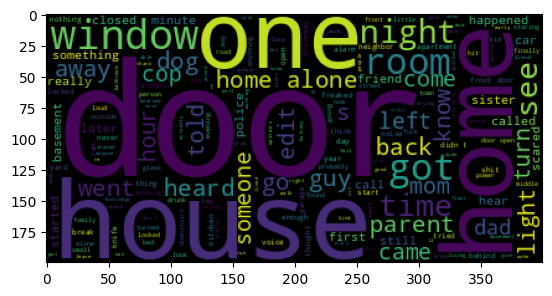

-----------


In [23]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - Recommender system <a class="anchor" id="chapter3"></a>

Now, we use the clusters created from part 1 to build a recommender system.
The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we consider that products belonging to the same cluster are similar.

In [24]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,I was home alone at my dad's while he was work...,i was home alone at my dad's while he was work...,"[home, dad, work, night, ,, make, dinner, ., p...","home dad work night , make dinner . probably 1...",-1
1,1,Was home alone one night and it was close to H...,was home alone one night and it was close to h...,"[home, night, close, halloween, 2015, ., loud,...",home night close halloween 2015 . loud ass kno...,-1
2,2,The scariest thing that happened to me I didnt...,the scariest thing that happened to me i didnt...,"[scary, thing, happen, not, know, actually, ha...",scary thing happen not know actually happen fo...,-1
3,3,Probably pretty lame compared to most stories ...,probably pretty lame compared to most stories ...,"[probably, pretty, lame, compare, story, ., wo...",probably pretty lame compare story . work pret...,-1
4,4,[deleted],[deleted],"[[, delete, ]]",[ delete ],-1


1. Create a function named `find_similar_items` that will return the 5 item ids belonging to the same cluster as the product `item_id`.

In [25]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

In [26]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [27]:
product_id = int(input("What story would you like to read ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print(f"{bcolors.OKBLUE}Product found in database, description below :")
    print(item_desc)
    print()

    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')

What story would you like to read ? 1

Product found in database, description below :
was home alone one night and it was close to halloween in 2015. loud ass knock on the front door. i was eatting dinner, so i slowly but cautiously go to the front door. open it up and there is blood all over the front porch and no one there. kind of freaked out a bit thought it was a prank. called the cops because what the fuck ya know? they said they would send someone there. they called back and said someone was on a bike and fell and was bleeding bad and was going door to door asking for help. i missed the person, but one of my neighbours helped them out apparently. crazy.

Based on the analysis of the products' descriptions, you might also be interested by the following products : 

Item # 43
my sister and i where home alone, our parents were out with some friends. suddenly there was the voice of a young child downstairs, repeatedly screaming "mommy". 
after a few minutes i was finally able to go 

## Part 4 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example Sport and Politics.

1. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [28]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.315384,0.014568,-0.137617,0.048315,0.105944,-0.074017,-0.061630,-0.050198,-0.253581,-0.060029,0.375673,-0.041792,i was home alone at my dad's while he was work...
1,0.267024,-0.036743,0.043787,-0.022679,0.212317,0.322063,-0.042790,-0.174517,0.114605,-0.047790,-0.156603,-0.089692,was home alone one night and it was close to h...
2,0.325148,0.283762,-0.005103,0.387101,-0.093086,-0.183886,-0.174710,0.051511,-0.097151,0.112314,-0.036089,-0.199797,the scariest thing that happened to me i didnt...
3,0.235669,0.219452,0.027259,0.148868,0.092362,-0.122551,0.013147,0.120650,0.259661,-0.006712,0.240037,-0.355793,probably pretty lame compared to most stories ...
4,0.000040,-0.019477,0.002093,-0.053133,-0.067032,0.006073,-0.012657,0.055426,0.037828,-0.087910,-0.085628,-0.069102,[deleted]


Contrary to clustering, LSA allows to map each document to a mix of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Create a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document.

In [29]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.315384,0.014568,-0.137617,0.048315,0.105944,-0.074017,-0.061630,-0.050198,-0.253581,-0.060029,0.375673,-0.041792,i was home alone at my dad's while he was work...,topic_10
1,0.267024,-0.036743,0.043787,-0.022679,0.212317,0.322063,-0.042790,-0.174517,0.114605,-0.047790,-0.156603,-0.089692,was home alone one night and it was close to h...,topic_5
2,0.325148,0.283762,-0.005103,0.387101,-0.093086,-0.183886,-0.174710,0.051511,-0.097151,0.112314,-0.036089,-0.199797,the scariest thing that happened to me i didnt...,topic_3
3,0.235669,0.219452,0.027259,0.148868,0.092362,-0.122551,0.013147,0.120650,0.259661,-0.006712,0.240037,-0.355793,probably pretty lame compared to most stories ...,topic_11
4,0.000040,-0.019477,0.002093,-0.053133,-0.067032,0.006073,-0.012657,0.055426,0.037828,-0.087910,-0.085628,-0.069102,[deleted],topic_9


3. Count each main topic in the corpus

In [30]:
topic_encoded_df['main_topic'].value_counts()

main_topic
topic_0     18
topic_3      5
topic_2      4
topic_1      4
topic_5      3
topic_6      3
topic_7      3
topic_10     2
topic_11     2
topic_9      2
topic_8      2
topic_4      2
Name: count, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Use the attribute `components_` of the SVD model to print the 5 most important words in each topic.

In [31]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(),
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,10,100,11,12,14,15,16,18,1st,20,...,wtf,ya,yard,yeah,year,yell,yike,young,youngster,yunabug1988
topic_0,0.060006,0.012954,0.027463,0.034510,0.021322,0.035322,0.015797,0.010660,0.004372,0.018366,...,0.010665,0.011055,0.042854,0.009793,0.061783,0.030026,0.014386,0.044481,0.005867,0.008910
topic_1,0.026209,0.013549,0.012943,0.010608,0.001495,0.000861,0.012954,0.011754,0.013033,0.025429,...,0.007418,0.004960,0.105950,0.013944,0.015607,0.019132,0.000334,0.013131,0.014187,0.003371
topic_2,0.064898,0.001297,0.036852,0.007780,0.033894,0.028748,0.000260,0.008106,0.012591,0.015163,...,0.010542,0.006626,0.009086,0.004604,0.046087,0.006702,0.006067,0.003038,0.016404,0.016463
topic_3,0.032707,0.011836,0.062064,0.039630,0.023670,0.028394,0.020427,0.000667,0.006418,0.014869,...,0.008296,0.003863,0.068860,0.002271,0.041911,0.002573,0.057971,0.070763,0.007621,0.020612
topic_4,0.038168,0.021002,0.039055,0.006114,0.074374,0.044718,0.022042,0.033096,0.000908,0.015174,...,0.017497,0.030741,0.014555,0.007426,0.005352,0.016081,0.032085,0.028106,0.009152,0.066619


In [32]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['door', 'home', 'house', 'window', 'hear']

-------------------------

TOPIC : topic_1
['light', 'turn', 'door', 'night', 'dog']

-------------------------

TOPIC : topic_2
['dog', 'sit', 'room', 'window', 'power']

-------------------------

TOPIC : topic_3
['guy', 'car', 'power', 'edit', 'kitchen']

-------------------------

TOPIC : topic_4
['door', 'alarm', 'mom', 'basement', 'edit']

-------------------------

TOPIC : topic_5
['fall', 'year', 'earthquake', 'car', 'stair']

-------------------------

TOPIC : topic_6
['alarm', 'edit', 'movement', 'sister', 'basement']

-------------------------

TOPIC : topic_7
['parent', 'alarm', 'earthquake', 'garage', 'window']

-------------------------

TOPIC : topic_8
['beep', 'stare', 'garage', 'window', 'basement']

-------------------------

TOPIC : topic_9
['sister', 'fall', 'power', 'turn', 'house']

-------------------------

TOPIC : topic_10
['police', 'like', 'potato', 'doll', 'room']

-------------------------

TOPIC 

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [33]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.315384,0.014568,-0.137617,0.048315,0.105944,-0.074017,-0.061630,-0.050198,-0.253581,-0.060029,0.375673,-0.041792,i was home alone at my dad's while he was work...,topic_10
1,0.267024,-0.036743,0.043787,-0.022679,0.212317,0.322063,-0.042790,-0.174517,0.114605,-0.047790,-0.156603,-0.089692,was home alone one night and it was close to h...,topic_5
2,0.325148,0.283762,-0.005103,0.387101,-0.093086,-0.183886,-0.174710,0.051511,-0.097151,0.112314,-0.036089,-0.199797,the scariest thing that happened to me i didnt...,topic_3
3,0.235669,0.219452,0.027259,0.148868,0.092362,-0.122551,0.013147,0.120650,0.259661,-0.006712,0.240037,-0.355793,probably pretty lame compared to most stories ...,topic_11
4,0.000040,-0.019477,0.002093,-0.053133,-0.067032,0.006073,-0.012657,0.055426,0.037828,-0.087910,-0.085628,-0.069102,[deleted],topic_9


-------------------------

TOPIC  topic_0


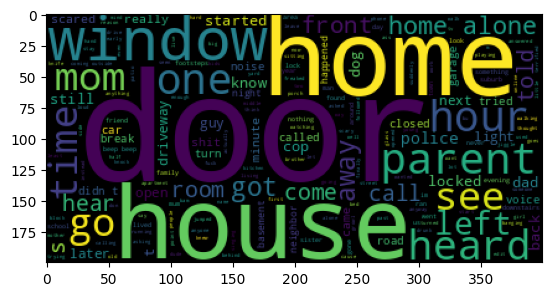


-------------------------

TOPIC  topic_1


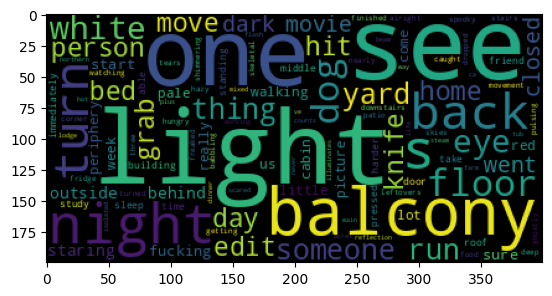


-------------------------

TOPIC  topic_2


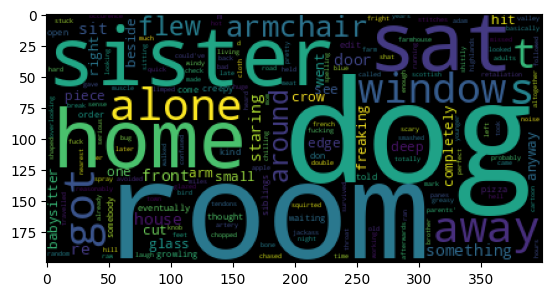


-------------------------

TOPIC  topic_3


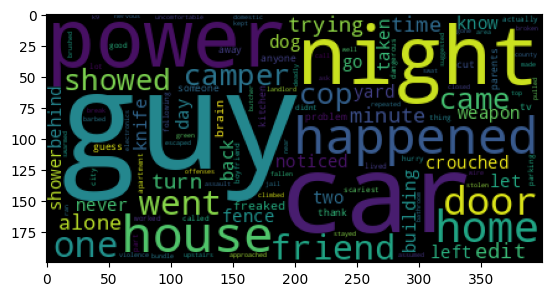


-------------------------

TOPIC  topic_4


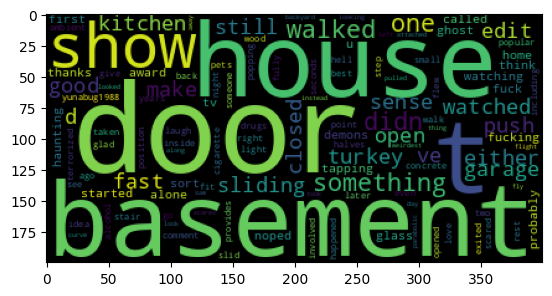


-------------------------

TOPIC  topic_5


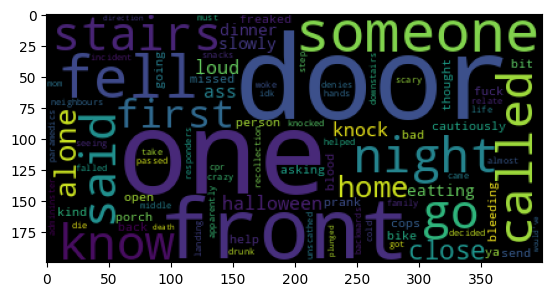


-------------------------

TOPIC  topic_6


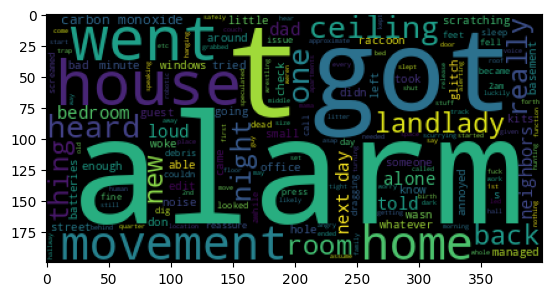


-------------------------

TOPIC  topic_7


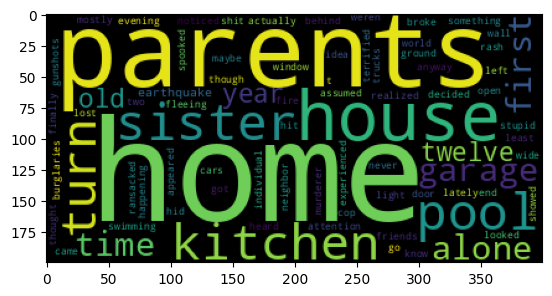


-------------------------

TOPIC  topic_8


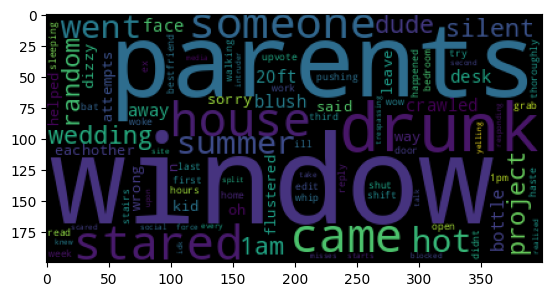


-------------------------

TOPIC  topic_9


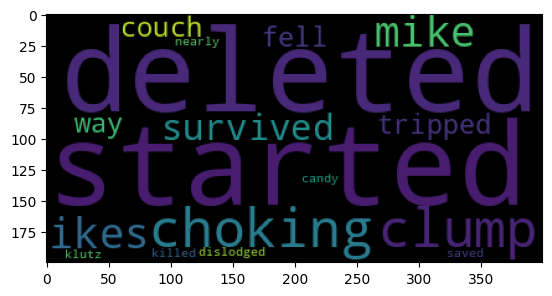


-------------------------

TOPIC  topic_10


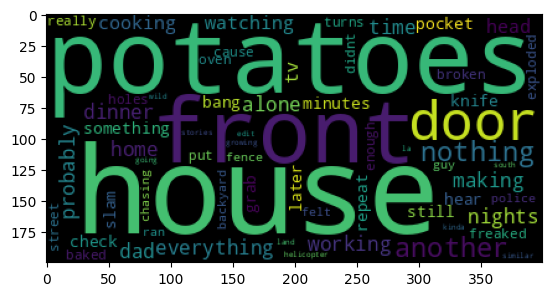


-------------------------

TOPIC  topic_11


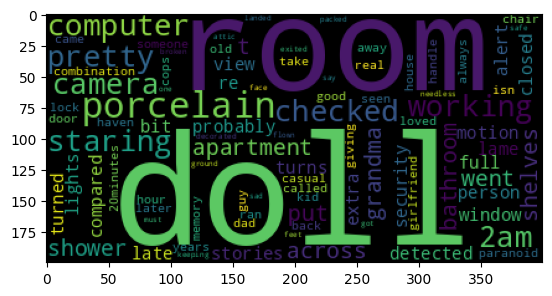

In [34]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)

    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue

    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()

    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.